## 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import  Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Загрузка данных

In [2]:
ROOT_DIRECTORY = '/datasets/'
try:
    labels = pd.read_csv(ROOT_DIRECTORY + 'faces/labels.csv')
except:
    ROOT_DIRECTORY = '../datasets/'
    labels = pd.read_csv(ROOT_DIRECTORY + 'faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
display(labels.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В датафрейме находятся названия файлов с фото людей и реальный возраст человека на этом фото. Пропусков нигде нету.

### Посмотрим размер выборки

In [5]:
print('Размер выборки:', labels.shape[0])

Размер выборки: 7591


### Постороим график распределения возраста в выборке

In [6]:
def build_hist(series, title='', xlabel='', bins=50, figsize=(12, 8)):
    fig = plt.figure(figsize=figsize)
    plt.hist(series, bins=50)
    plt.grid()
    plt.gca().set(xlabel=xlabel, ylabel='Частота')
    plt.xticks(fontsize=12); 
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=16)
    plt.show()

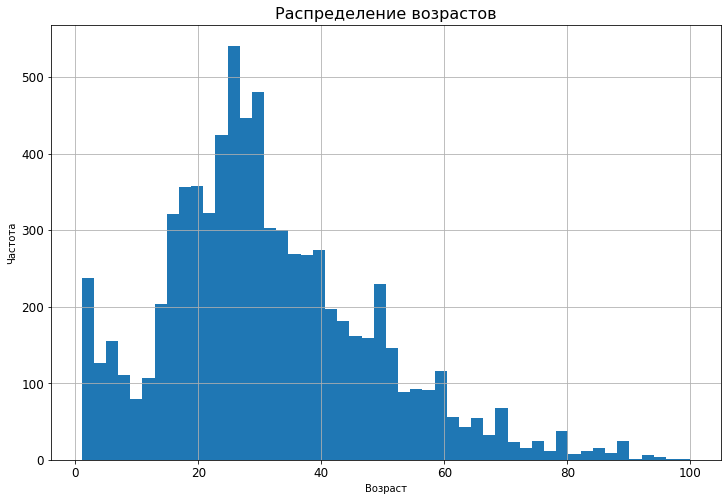

In [7]:
build_hist(labels.real_age, title='Распределение возрастов', xlabel='Возраст')

По распределению можно сказать что преобладают покупатели в возрасте от 18 до 40 лет.

Функция для загрузки фотографий

In [8]:
def get_photos():
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=ROOT_DIRECTORY + 'faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345) 
    return train_gen_flow

### Посмотрим на 12 фотографий.

Found 7591 validated image filenames.


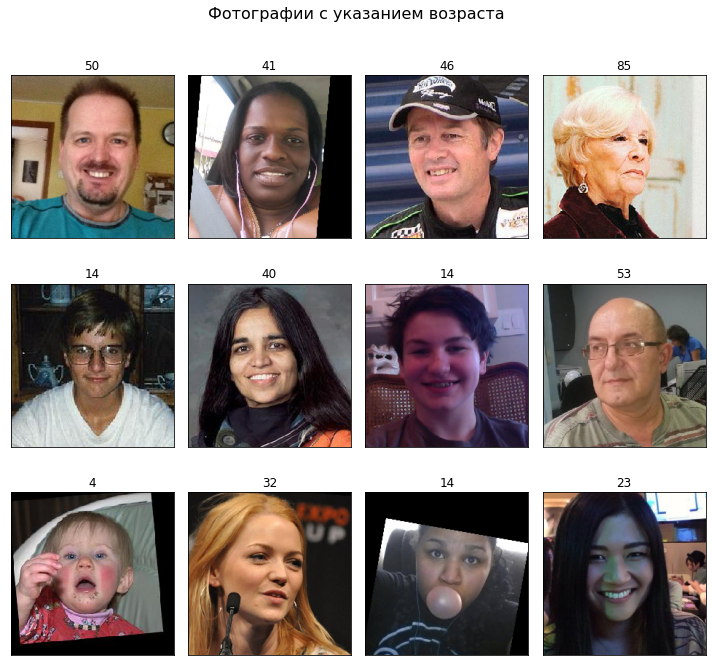

In [9]:
features, target = next(get_photos())

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Фотографии с указанием возраста', fontsize=16)
for i in range(12):
    fig.add_subplot(3, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i], fontsize=12)
    plt.tight_layout()

### Вывод

Из полученных результатов можно сделать вывод, что в датасете много лишних данных с детьми, которые сами по себе покупателями быть не могут. Много лишних элементов на фотографиях - очки, пузыри от жевательной резинки, наушники, всё это будет добавлять лишний шум в обучающих данных. Всё это может усложнить обучение модели.

Для нормального обучения модели не думаю что нужны какие-то деформации изображений. Все фото плюс/минус вертикальные, вытягивание/сжимание напрямую может состарить/омолодить человека или сделать неестественным. По этому всякого рода трансформации увеличат время обучения, но вряд ли дадут какой-либо прирост к результату.

## 2. Обучение модели

### Необходимые функции для обучения модели

#### Получение тренировочной выборки

In [10]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

#### Получение тестовой выборки

In [11]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale = 1/255)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

#### Создание модели

In [12]:
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0005), loss='mse', metrics=['mae'])

    return model

#### Обучение модели

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model

#### Результат работы модели:

Train for 356 steps, validate for 119 steps

Epoch 1/10

2021-08-03 21:21:04.117682: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2021-08-03 21:21:08.310994: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 104s - loss: 204.2083 - mae: 10.7933 - val_loss: 374.3766 - val_mae: 14.4533

Epoch 2/10

356/356 - 37s - loss: 127.9139 - mae: 8.6143 - val_loss: 294.1965 - val_mae: 12.8521

Epoch 3/10

356/356 - 37s - loss: 92.2778 - mae: 7.4166 - val_loss: 123.5797 - val_mae: 8.4125

Epoch 4/10

356/356 - 37s - loss: 66.8286 - mae: 6.3206 - val_loss: 206.0126 - val_mae: 11.5908

Epoch 5/10

356/356 - 37s - loss: 45.8644 - mae: 5.2431 - val_loss: 106.2461 - val_mae: 7.7154

Epoch 6/10

356/356 - 37s - loss: 32.1369 - mae: 4.4273 - val_loss: 93.2572 - val_mae: 7.3342

Epoch 7/10

356/356 - 37s - loss: 26.0675 - mae: 3.9540 - val_loss: 99.0246 - val_mae: 7.7039

Epoch 8/10

356/356 - 37s - loss: 19.7283 - mae: 3.4516 - val_loss: 93.4412 - val_mae: 7.3915

Epoch 9/10

356/356 - 37s - loss: 17.6359 - mae: 3.2185 - val_loss: 84.7573 - val_mae: 6.9791

Epoch 10/10

356/356 - 37s - loss: 15.2863 - mae: 3.0006 - val_loss: 90.5686 - val_mae: 7.2946

119/119 - 9s - loss: 90.5686 - mae: 7.2946

Test MAE: 7.2946

## 3. Анализ обученной модели

Модель показала что может не плохо различать возраст людей, ошибка в среднем на 7 лет это не так много, учитывая что простой человек точнее угадать возраст вряд ли в сможет. А учитывая что основные фото в базе это люди среднего возраста, так там очень сильно размыты возрастные характеристики. Зная такую характеристику, робот будет запрашивать паспорт у людей моложе (по предсказанию) 26 лет. Не думаю что кто-то обидется на него.

Как изначально, из анализа предоставленных для обучения базы, и было предположено - любые дополнительные изображения, произведённые с помощью любых деформаций, здесь были излишни. Это увеличило бы время обучения и не дало бы прироста качества.

Удаление детей до 5 лет, думаю, так же могло бы улучшить качество предсказания модели.

Исходя из тенденции, увеличение эпох могло бы привести к возростанию качества предсказаний модели, но и на 10 эпохах предсказания достаточно точные.

Модель можно улучшать за счёт увеличения количества эпох и за счёт параметра lr в Adam().

Так как для бизнеса эта модель должна решать 2 основные задачи: определение возрастной группы покупателя и контроль продажи алкоголя, то эта модель вполне подойдёт для решения этих задач. Погрешность в 7 лет допустима при определении возрастной группы. А обе эти задачи, по сути, к этому и сводятся.